In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:


# Load the uploaded file
df = pd.read_csv('data/full_grouped.csv')
df2 = pd.read_csv('data/full_grouped.csv')

# Display the first few rows of the dataset to inspect its structure
df.head(), df.info()
df2.head(), df2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35156 entries, 0 to 35155
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            35156 non-null  object
 1   Country/Region  35156 non-null  object
 2   Confirmed       35156 non-null  int64 
 3   Deaths          35156 non-null  int64 
 4   Recovered       35156 non-null  int64 
 5   Active          35156 non-null  int64 
 6   New cases       35156 non-null  int64 
 7   New deaths      35156 non-null  int64 
 8   New recovered   35156 non-null  int64 
 9   WHO Region      35156 non-null  object
dtypes: int64(7), object(3)
memory usage: 2.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35156 entries, 0 to 35155
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            35156 non-null  object
 1   Country/Region  35156 non-null  object
 2   Confirmed       35156 n

(         Date Country/Region  Confirmed  Deaths  Recovered  Active  New cases  \
 0  2020-01-22    Afghanistan          0       0          0       0          0   
 1  2020-01-22        Albania          0       0          0       0          0   
 2  2020-01-22        Algeria          0       0          0       0          0   
 3  2020-01-22        Andorra          0       0          0       0          0   
 4  2020-01-22         Angola          0       0          0       0          0   
 
    New deaths  New recovered             WHO Region  
 0           0              0  Eastern Mediterranean  
 1           0              0                 Europe  
 2           0              0                 Africa  
 3           0              0                 Europe  
 4           0              0                 Africa  ,
 None)

The dataset contains 35,156 entries with the following columns:

1. Date: The date of the record.
2. Country/Region: The name of the country or region.
3. Confirmed: Total confirmed COVID-19 cases.
4. Deaths: Total deaths due to COVID-19.
5. Recovered: Total recoveries from COVID-19.
6. Active: Total active cases (calculated as Confirmed - Deaths - Recovered).
7. New cases: Newly confirmed cases for the day.
8. New deaths: Newly reported deaths for the day.
9. New recovered: Newly reported recoveries for the day.
10. WHO Region: WHO-defined regional grouping of the country/region.

In [3]:
df.describe()

,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered
count,3.515600e+04,35156.000000,3.515600e+04,3.515600e+04,35156.00000,35156.000000,35156.000000
mean,2.356663e+04,1234.068239,1.104813e+04,1.128443e+04,469.36375,18.603339,269.315593
std,1.499818e+05,7437.238354,6.454640e+04,8.997149e+04,3005.86754,115.706351,2068.063852
min,0.000000e+00,0.000000,0.000000e+00,-2.000000e+00,0.00000,-1918.000000,-16298.000000
25%,1.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.00000,0.000000,0.000000
50%,2.500000e+02,4.000000,3.300000e+01,8.500000e+01,2.00000,0.000000,0.000000
75%,3.640250e+03,78.250000,1.286250e+03,1.454000e+03,75.00000,1.000000,20.000000
max,4.290259e+06,148011.000000,1.846641e+06,2.816444e+06,77255.00000,3887.000000,140050.000000


In [6]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()

missing_values

Date              0
Country/Region    0
Confirmed         0
Deaths            0
Recovered         0
Active            0
New cases         0
New deaths        0
New recovered     0
WHO Region        0
dtype: int64

The dataset does not contain any missing values

In [7]:
# Check for duplicate values in the dataset
duplicates = df.duplicated().sum()

duplicates


0

The dataset does not contain any duplicate values

In [8]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

df.head()

,Date,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,WHO Region
0,2020-01-22,Afghanistan,0,0,0,0,0,0,0,Eastern Mediterranean
1,2020-01-22,Albania,0,0,0,0,0,0,0,Europe
2,2020-01-22,Algeria,0,0,0,0,0,0,0,Africa
3,2020-01-22,Andorra,0,0,0,0,0,0,0,Europe
4,2020-01-22,Angola,0,0,0,0,0,0,0,Africa


The Date column is now in datetime format.

### Perform feature engineering

In [9]:
# Calculate daily growth rate for confirmed cases
df['Daily Growth Rate (%)'] = df['New cases'] / (df['Confirmed'] - df['New cases'] + 1) * 100

# Calculate mortality ratio (deaths per confirmed cases)
df['Mortality Ratio (%)'] = (df['Deaths'] / df['Confirmed']) * 100

# Replace infinities or NaN values resulting from zero division with 0
df.fillna(0, inplace=True)
df.replace([float('inf'), -float('inf')], 0, inplace=True)

# Display summary of the updated dataset
df[['Date', 'Country/Region', 'Daily Growth Rate (%)', 'Mortality Ratio (%)']].head()




,Date,Country/Region,Daily Growth Rate (%),Mortality Ratio (%)
0,2020-01-22,Afghanistan,0.0,0.0
1,2020-01-22,Albania,0.0,0.0
2,2020-01-22,Algeria,0.0,0.0
3,2020-01-22,Andorra,0.0,0.0
4,2020-01-22,Angola,0.0,0.0


Feature engineering has been completed. New columns added:

1. Daily Growth Rate (%): Measures the percentage increase in confirmed cases from the previous day.
2. Mortality Ratio (%): The proportion of deaths relative to confirmed cases, expressed as a percentage.

### Perform Exploratory data analysis (EDA)

Conduct exploratory data analysis (EDA) to visualize trends and identify correlations.

### Trends Analysis Over Time

To understand the evolution of COVID-19 cases, deaths, and recoveries globally.

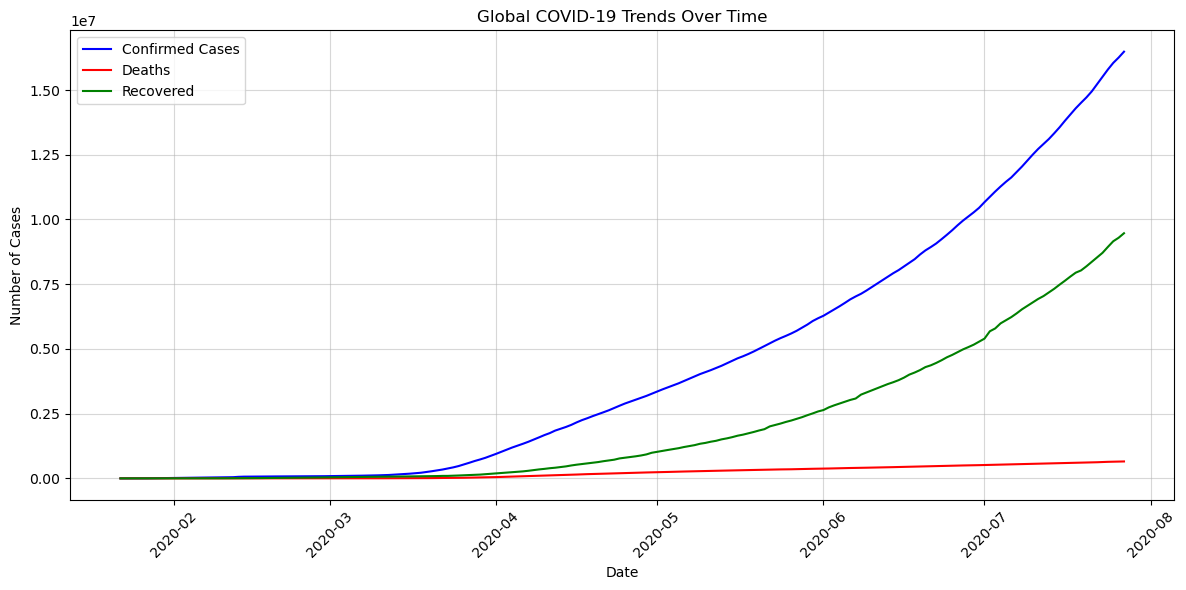

In [10]:
# Aggregate data by date
daily_summary = df.groupby('Date')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

# Plot line graphs
plt.figure(figsize=(12, 6))
plt.plot(daily_summary['Date'], daily_summary['Confirmed'], label='Confirmed Cases', color='blue')
plt.plot(daily_summary['Date'], daily_summary['Deaths'], label='Deaths', color='red')
plt.plot(daily_summary['Date'], daily_summary['Recovered'], label='Recovered', color='green')

plt.title('Global COVID-19 Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.xticks(rotation=45)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


The chart above highlights the global trends in confirmed COVID-19 cases, deaths, and recoveries between February and August 2020.

1. Confirmed Cases: The number of confirmed COVID-19 cases rose exponentially during the observed period. Starting with minimal cases in February, the count surpassed 15 million by late July. This sharp increase underscores the rapid global transmission of the virus and highlights the challenges faced in containing its spread.

2. Deaths: The cumulative global deaths, represented by a red line, increased at a much slower rate compared to confirmed cases. By August, the death toll had risen steadily but remained significantly lower than the number of confirmed cases, suggesting a relatively low case-fatality rate during this period.

3. Recoveries: The number of recoveries also grew steadily, trailing behind confirmed cases but far exceeding the death count. This growth reflects the efforts of healthcare systems worldwide to treat patients and mitigate the pandemic's impact.

### Regional Analysis

To compare COVID-19 cases across WHO regions.

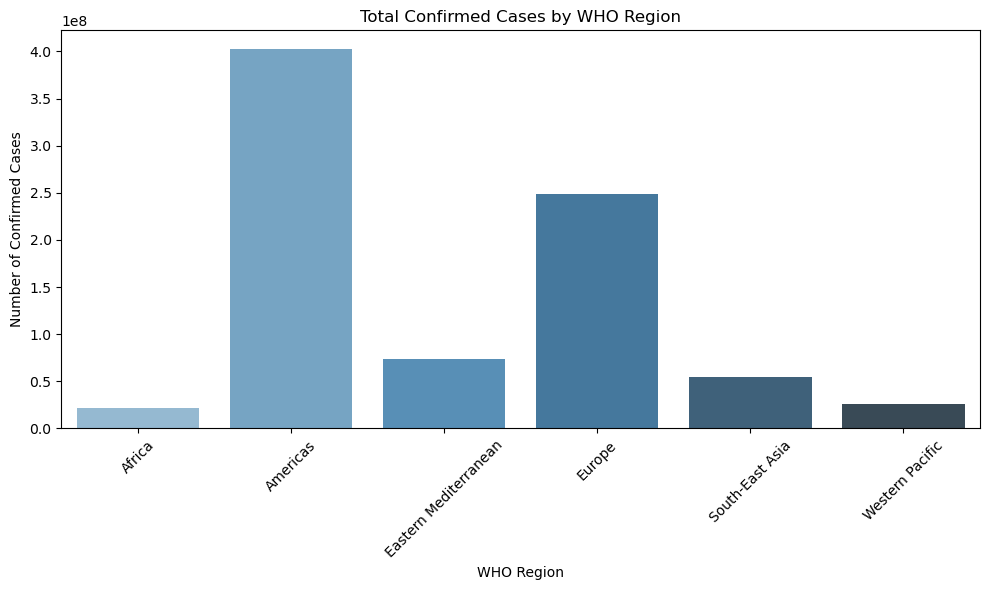

In [11]:
# Aggregate data by WHO Region
region_summary = df.groupby('WHO Region')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

# Plot bar chart for confirmed cases by region
plt.figure(figsize=(10, 6))
sns.barplot(data=region_summary, x='WHO Region', y='Confirmed', palette='Blues_d')
plt.title('Total Confirmed Cases by WHO Region')
plt.xlabel('WHO Region')
plt.ylabel('Number of Confirmed Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This chart illustrates the distribution of total confirmed COVID-19 cases by World Health Organization (WHO) regions. Here are key insights:

1. Americas Lead in Confirmed Cases: The Americas region has the highest number of confirmed cases, exceeding 4 million. This reflects the significant impact of the pandemic in countries like the United States and Brazil, which were among the hardest hit during the early phases.

2. Europe as the Second Most Affected: Europe ranks second in confirmed cases, with numbers close to those of the Americas. This aligns with the widespread outbreaks in countries like Italy, Spain, and the United Kingdom during the initial stages of the pandemic.

3. Moderate Impact in Eastern Mediterranean and South-East Asia: The Eastern Mediterranean and South-East Asia regions show a moderate number of confirmed cases. These regions faced varying levels of spread, with countries like India and Iran contributing significantly to the figures.

4. Lower Impact in Africa and the Western Pacific: Africa and the Western Pacific have the lowest numbers of confirmed cases. In Africa, this may be attributed to younger populations, lower testing rates, and possible underreporting. The Western Pacific, which includes countries like China, Japan, and Australia, likely benefited from early containment measures and robust public health responses.
Observations:

5. The disparity in case numbers across regions highlights differences in population size, healthcare infrastructure, government responses, and testing capacities.

6. The Americas and Europe, with their high connectivity and urbanized populations, experienced a faster and broader spread of the virus compared to other regions.

### Mortality and Recovery Ratios by Region

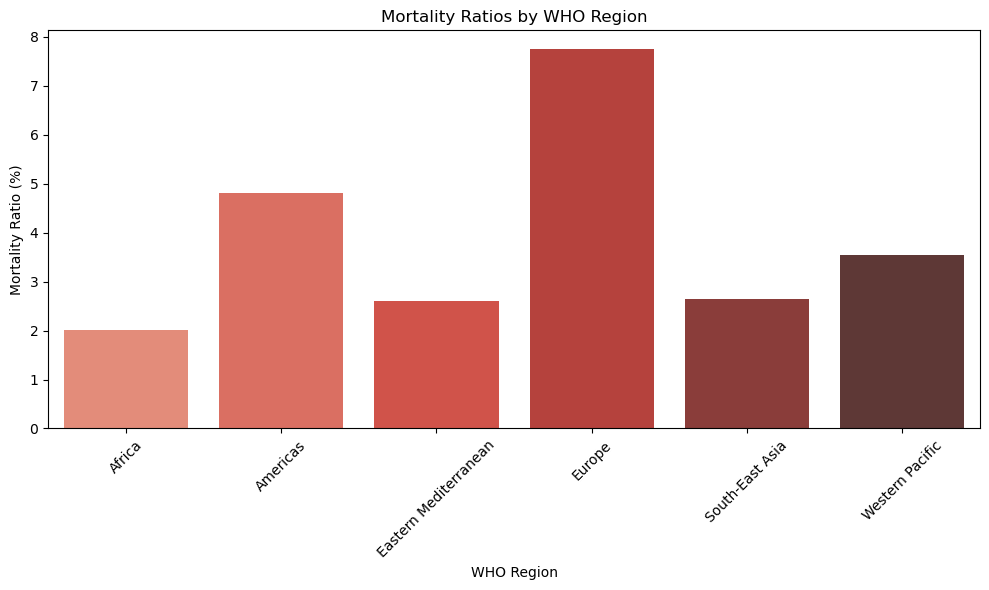

In [12]:
# Add calculated metrics
region_summary['Mortality Ratio (%)'] = (region_summary['Deaths'] / region_summary['Confirmed']) * 100
region_summary['Recovery Ratio (%)'] = (region_summary['Recovered'] / region_summary['Confirmed']) * 100

# Plot mortality ratio by region
plt.figure(figsize=(10, 6))
sns.barplot(data=region_summary, x='WHO Region', y='Mortality Ratio (%)', palette='Reds_d')
plt.title('Mortality Ratios by WHO Region')
plt.xlabel('WHO Region')
plt.ylabel('Mortality Ratio (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This bar chart illustrates the Mortality Ratios (%) by WHO Region during the COVID-19 pandemic with Europe, Americas and Western Pacific recording the highest mortality ration of 7%, 5% and 4% respectively.


### Correlation Analysis

To identify relationships between features (e.g., active cases, deaths, growth rates).

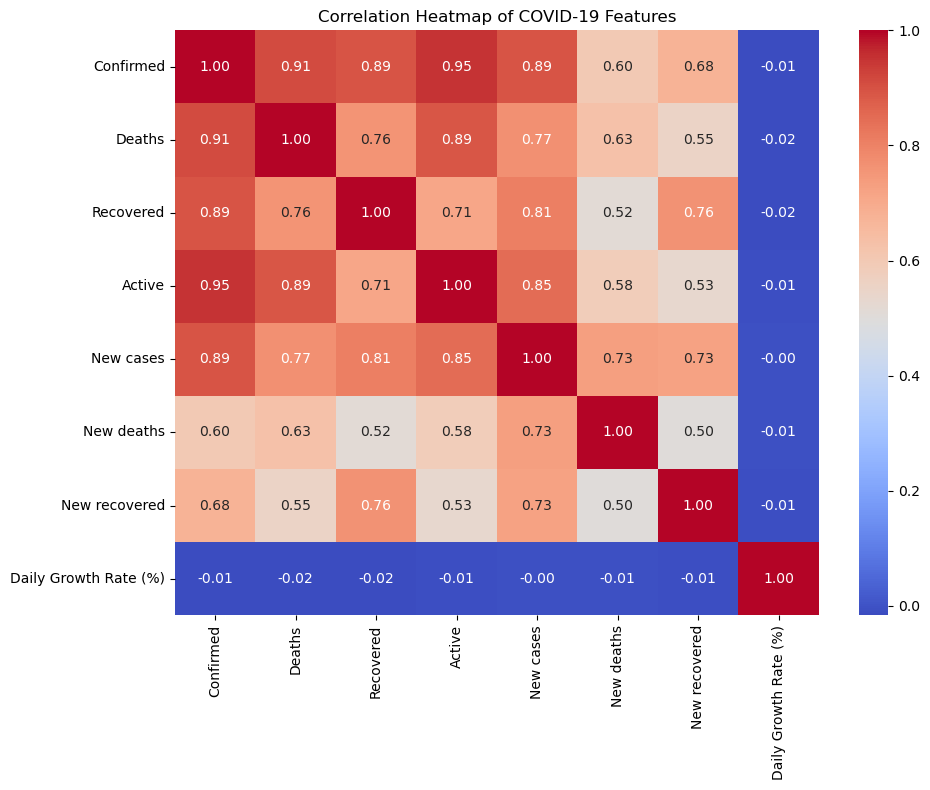

In [13]:
# Select numerical columns for correlation
numerical_features = ['Confirmed', 'Deaths', 'Recovered', 'Active', 'New cases', 'New deaths', 'New recovered', 'Daily Growth Rate (%)']
correlation_matrix = df[numerical_features].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of COVID-19 Features')
plt.tight_layout()
plt.show()


This correlation heatmap provides a visual representation of the relationships between various COVID-19 features, indicating that there is a strong correlation between confirmed cases and deaths (0.91), confirmed cases and recovered (0.89) and active cases and confirmed cases (0.95).

This means that as the number of confirmed cases rises, deaths tend to increase proportionally. Also, it also suggests that recovery counts increase with higher case numbers, likely reflecting better case management over time and  highlights that most active cases are a subset of confirmed cases.

### Scatter Plot for Outliers

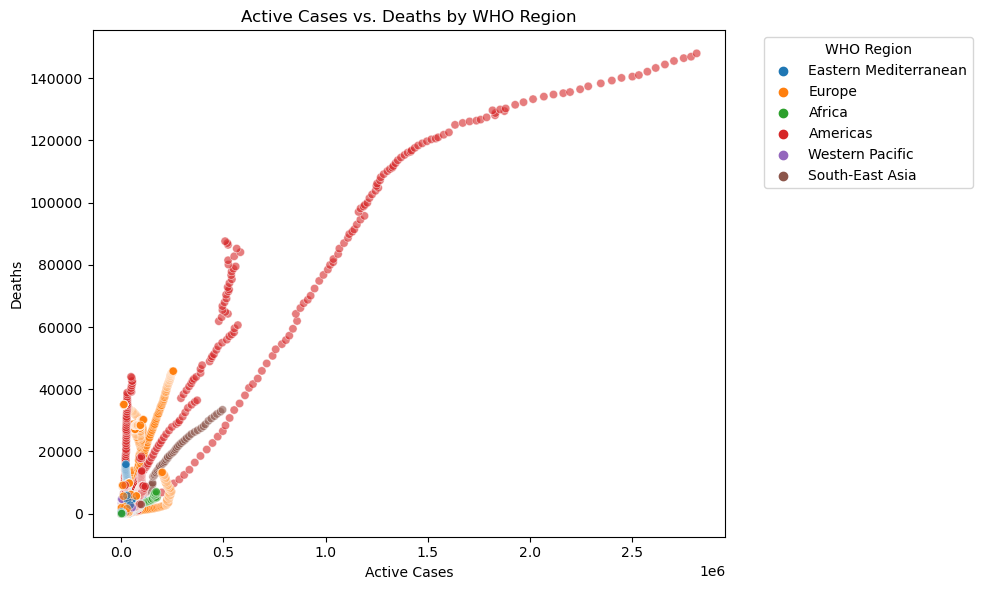

In [14]:
# Scatter plot: Active Cases vs. Deaths
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Active', y='Deaths', hue='WHO Region', alpha=0.6)
plt.title('Active Cases vs. Deaths by WHO Region')
plt.xlabel('Active Cases')
plt.ylabel('Deaths')
plt.legend(title='WHO Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


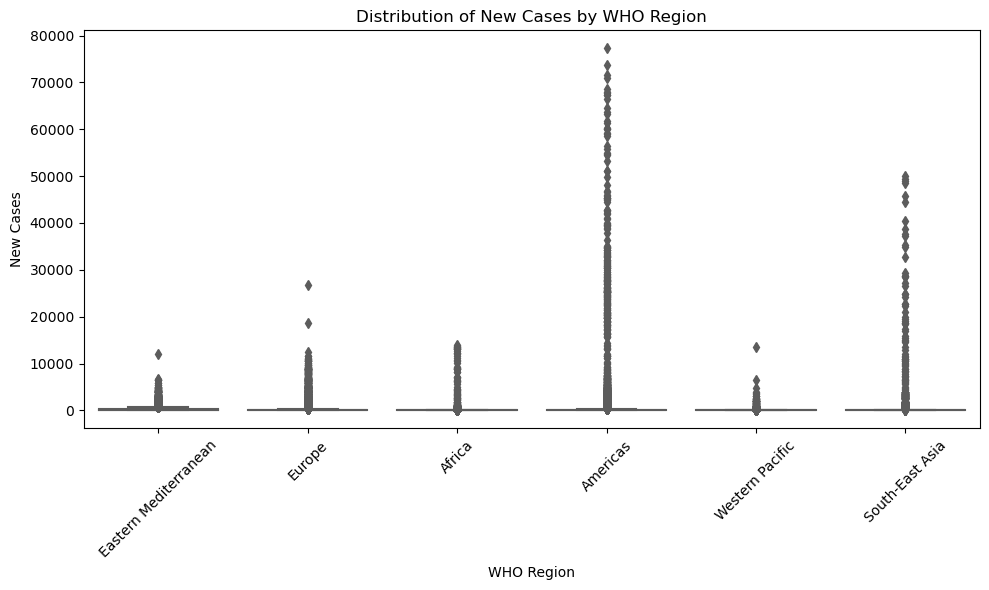

In [15]:
# Boxplot for outliers in new cases
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='WHO Region', y='New cases', palette='coolwarm')
plt.title('Distribution of New Cases by WHO Region')
plt.xlabel('WHO Region')
plt.ylabel('New Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Demographic and Environmental Factors

To uncover the role of demographics (e.g., population density, age) and environmental conditions (e.g., temperature) in influencing COVID-19 spread.

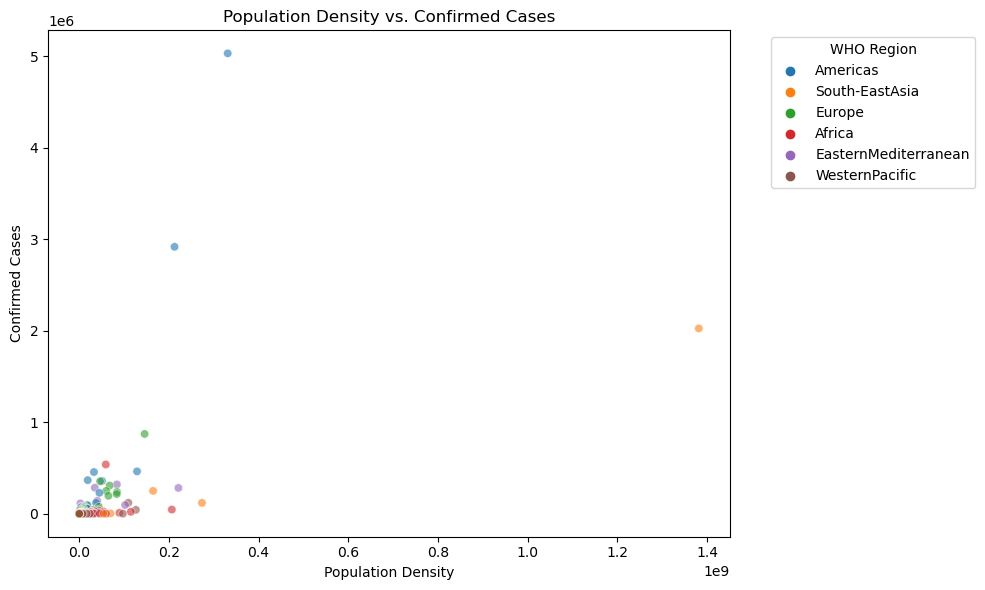

In [19]:
# Population Density vs. Cases
df_population = pd.read_csv('data/worldometer_data.csv')

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_population, x='Population', y='TotalCases', hue='WHO Region', alpha=0.6)
plt.title('Population Density vs. Confirmed Cases')
plt.xlabel('Population Density')
plt.ylabel('Confirmed Cases')
plt.legend(title='WHO Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Model Development

To predict COVID-19 trends and outcomes, we'll apply two types of models:

1. Time-Series Models to predict the number of COVID-19 cases or deaths over time using historical data.
2. Classification Models to classify outcomes like recovery (Recovered vs. Not Recovered) or risk levels.



#### Time-Series Models using prophet

In [7]:
# Select and rename relevant columns
time_series = df[['Date', 'Confirmed']].copy()
time_series.columns = ['ds', 'y']
time_series['ds'] = pd.to_datetime(time_series['ds'])


In [8]:
# Initialize and fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(time_series)


15:34:29 - cmdstanpy - INFO - Chain [1] start processing
15:34:42 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
# Create a future dataframe (next 30 days)
future = prophet_model.make_future_dataframe(periods=30)

# Generate the forecast
forecast = prophet_model.predict(future)


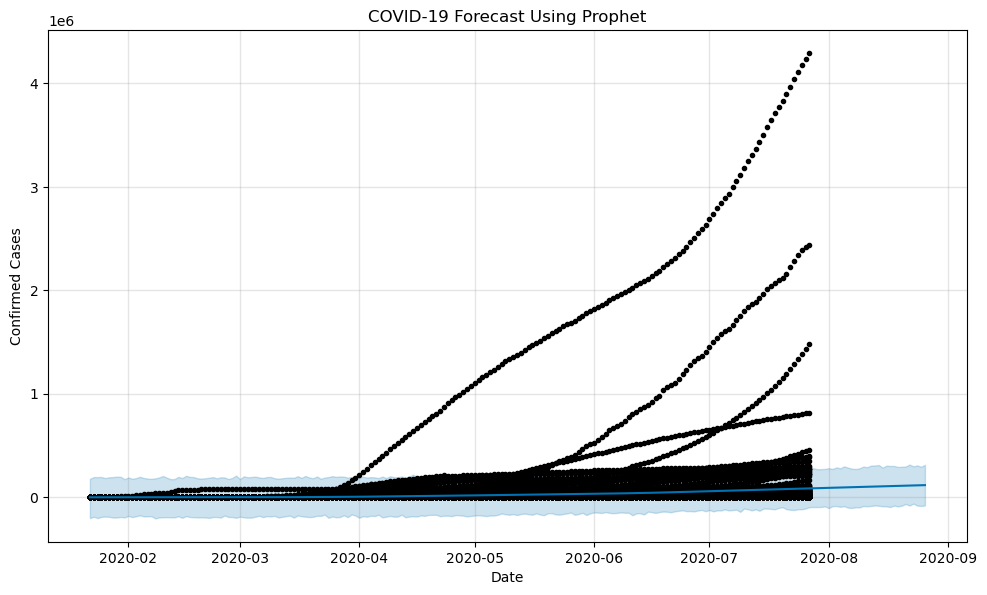

In [10]:


# Plot the forecast
fig = prophet_model.plot(forecast)
plt.title('COVID-19 Forecast Using Prophet')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.show()


In [11]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


            ds           yhat    yhat_lower     yhat_upper
213 2020-08-22  112971.351248 -80353.139879  315941.631010
214 2020-08-23  113992.866568 -61994.530826  298641.828555
215 2020-08-24  114995.294051 -80747.026840  308176.133322
216 2020-08-25  115939.923711 -84580.804727  294565.855225
217 2020-08-26  117032.864405 -78828.745740  313495.853728


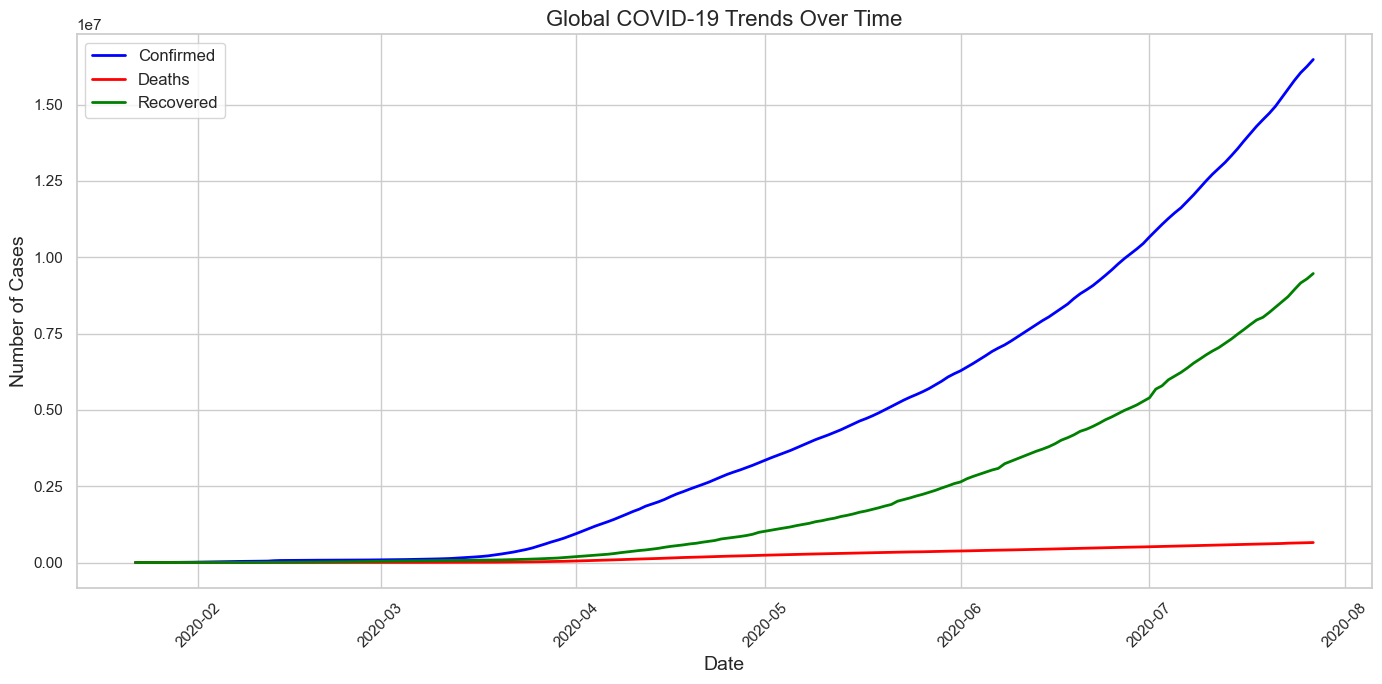

In [18]:


# Set plot style for consistency
sns.set(style="whitegrid")

# Example Visualization: Global trends over time for Confirmed, Deaths, and Recovered cases
global_trends = df.groupby('Date')[['Confirmed', 'Deaths', 'Recovered']].sum()

# Plot trends over time
plt.figure(figsize=(14, 7))
plt.plot(global_trends.index, global_trends['Confirmed'], label='Confirmed', color='blue', linewidth=2)
plt.plot(global_trends.index, global_trends['Deaths'], label='Deaths', color='red', linewidth=2)
plt.plot(global_trends.index, global_trends['Recovered'], label='Recovered', color='green', linewidth=2)
plt.title('Global COVID-19 Trends Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Cases', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Classification Models

In [24]:

daily_summary = df[['Date', 'Confirmed', 'Deaths', 'Recovered', 'Active']].groupby('Date').sum()

# Create a classification label based on Confirmed cases
def categorize_cases(value):
    if value < 1000:
        return 'Low'
    elif 1000 <= value < 10000:
        return 'Moderate'
    else:
        return 'High'

daily_summary['Case_Level'] = daily_summary['Confirmed'].apply(categorize_cases)

# View the updated data
print(daily_summary.head())



            Confirmed  Deaths  Recovered  Active Case_Level
Date                                                       
2020-01-22        555      17         28     510        Low
2020-01-23        654      18         30     606        Low
2020-01-24        941      26         36     879        Low
2020-01-25       1434      42         39    1353   Moderate
2020-01-26       2118      56         52    2010   Moderate


In [25]:
# Features and labels
X = daily_summary[['Deaths', 'Recovered', 'Active']]
y = daily_summary['Case_Level']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:


# Train the Random Forest classifier
clf = RandomForestClassifier(random_state=42, n_estimators=100)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00        36
    Moderate       1.00      1.00      1.00         2

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38

Confusion Matrix:
 [[36  0]
 [ 0  2]]


### Feature Importance


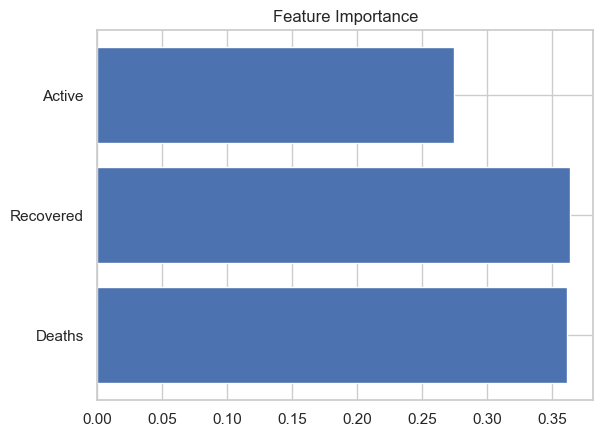

In [31]:
# Feature importance
importance = clf.feature_importances_
plt.barh(X.columns, importance)
plt.title("Feature Importance")
plt.show()
